<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Fourier Pseudospectral Method - Acoustic Waves in 1D</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* David Vargas ([@dvargas](https://github.com/davofis))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))
---

## Basic Equations
Below there is the code solving the 1D acoustic wave equation

\begin{equation}
\partial_t^2 p(x,t) = c(x)^2 \ \partial_x^2 p(x,t) + s(x,t)
\end{equation}

This exercise covers the following aspects:

* presenting you with an implementation of the 1D acoustic wave equation
* allowing you to explore the benefits of calculating exact spatial derivatives (up to machine precision)
* determination of the stability limit for the Pseudospectral Fourier Method
* exploration of numerical dispersion
* comparison of the Pseudospectral Fourier Method with a 5-point Finite Difference scheme
## Exercises

### 1. Getting started
Before you start it is good practice to immediately make a copy of the original notebook (e.g., X_orig.ipynb). 
Run the simulation code. Relate the spatial derivative calculation via Fast Fourier Transform (FFT) with the numerical algorithm we developed in the course. Understand the input parameters for the simulation and the plots that are generated. 

### 2. Stability
Determine numerically the stability limit of the code as accurately as possible by varying the Courant criterion eps. (Hint: The Courant criterion is defined as eps = (velocity * dt) / dx . With this information you can calculate the maximum possible, stable time step. )

### 3. Heterogeneous models
Implement a positive velocity discontinuity of 50% at the centre of the 1D domain. Observe the reflection as a function of dominant wavelength (i.e., change the dominant frequency of the source wavelet).


### 4. Comparison to Finite Differences
Go back to a homogeneous velocity distribution and compare the resulting seismograms with a 5-point finite difference solution by setting "FD = 1" in the parameter initialization. Compare and discuss the computational setups in terms of memory requirements, number of time steps, Courant criterion and computatational time.

### Have fun!

In [1]:
# This is a configuration step for the exercise. Please run it before calculating the derivative!
import numpy as np
import matplotlib.pyplot as plt
from ricker import ricker 

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

### 1. Fourier derivative method 

In [2]:
def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

### 2. Initialization of setup

In [3]:
# Basic parameters
# ---------------------------------------------------------------
nt    = 3000    # number of time steps
c     = 343.    # acoustic velocity
eps   = 0.2     # stability limit
isnap = 1000    # snapshot frequency
isx   = 1250    # source location
f0    = 60.     # Frequency (div by 5)
lw    = 1.25
ft    = 12
fs    = ft
iplot = 0
nx    = 2024    # number of grid points in x 

# pressure fields Initialization
p = np.zeros(nx) ; pnew = p ; pold = p ; d2p = p; dp = p   
ap = np.zeros(nx); apnew = ap; apold = ap; ad2p = ap; adp = ap 
sp = np.zeros(nx); spnew = sp; spold = sp; sd2p = sp; sdp = p 

dx = 1250./(nx-1)  # calculate space increment
x = np.arange(0, nx)*dx   # initialize space coordinates
xmin = min(x)
xmax = max(x)
dt = eps*dx/c; # calculate time step from stability criterion

### 3. Source Initialization 

In [4]:
# source time function
# ---------------------------------------------------------------
t   = np.arange(1, nt+1)*dt  # initialize time axis
T0  = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt) 
src[0:np.size(tmp)] = tmp
lam = c*T0

#spatial source function
# ---------------------------------------------------------------
sigma = 2*dx
x0 = x[isx-1]
sg = np.exp(-1/sigma**2 *(x - x0)**2); sg = sg/np.amax(sg)

### 4. Time Extrapolation
The final solution for our 2D acoustic wave problem after taking into account the finite differences time extrapolation can be written as 

\begin{equation}
p_{j,k}^{n+1} = dt^2c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + dt^2s_{j,k}^{n} + 2p_{j,k}^{n} - p_{j,k}^{n-1}
\end{equation}

In order to compare the above numerical solution, we implement a 5-point finite difference operator to compute spatial derivatives

\begin{equation}
\partial_t^2 p(x,t) = \frac{-p(x,t+2\mathrm{d}t) + 16p(x,t+\mathrm{d}t) - 30p(x,t) + 16p(x,t-\mathrm{d}t) - p(x,t-2\mathrm{d}t)}{12\mathrm{d}t^2} 
\end{equation}

temporal derivative is done with a 3-point finite difference operator.

#### Numerical dispersion and anysotropy

One of the most significant characteristics of the fourier method is the low numerical dispersion in comparison with the finite difference method. The snapshots displayed below for both solutions allow us to brifly comment two significant observations:

1) There is strong anisotropic dispersion behaviour visible for the finite-difference solution. The most accurate direction occur at $\theta = \pi/4$ 

2) The Fourier solution do not exhibit significant dispersion, but the most importantly, it does not seem to be directionally dependent. In other words the error is isotropic. 

0


/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/Programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:71: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home

0
0


<IPython.core.display.Javascript object>


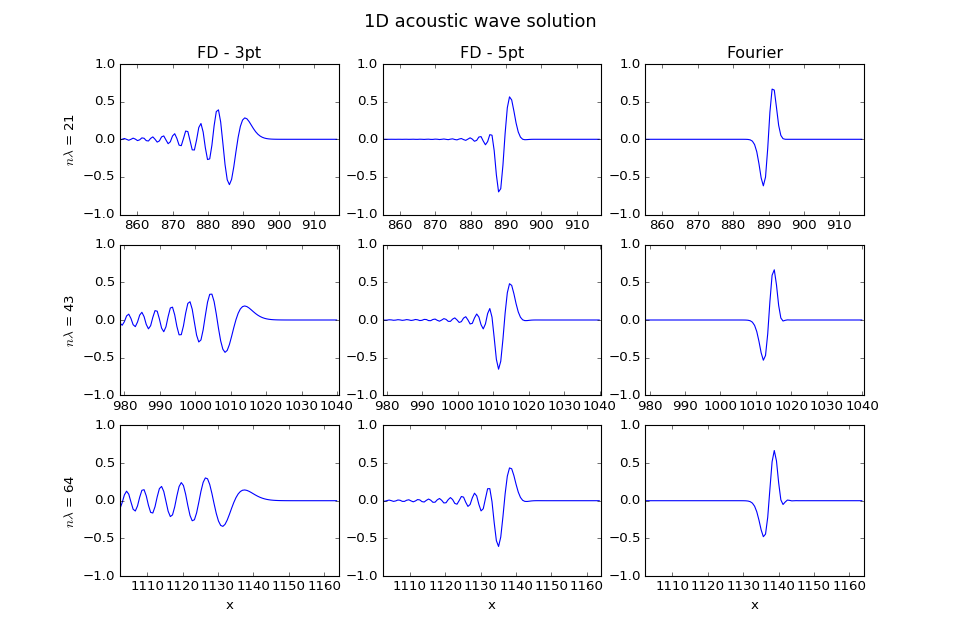

In [5]:
# Initialize animated plot
# ---------------------------------------------------------------
#fig = plt.figure(figsize=(12,6))
#ax1 = fig.add_subplot(1,2,1)
#ax2 = fig.add_subplot(1,2,2)
#line1 = ax1.imshow(sp_sec, interpolation="nearest", cmap=plt.cm.RdBu)
#line2 = ax2.imshow(ap_sec, interpolation="nearest", cmap=plt.cm.RdBu)
#ax1.set_title('Fourier Method', size=14)
#ax2.set_title('Finite-Difference Method', size=14)

#plt.ion()   # set interective mode
#plt.show()

plt.figure(figsize=(12,8), dpi=80) 
plt.suptitle("1D acoustic wave solution", fontsize=16)

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------           
    sd2p  = fourier_derivative_2nd(sp, dx)      # 2nd space derivative     
    spnew = 2*sp - spold + c**2 * dt**2 * sd2p  # Time Extrapolation   
    spnew = spnew + sg*src[it]*dt**2            # Add sources   
    spold, sp = sp, spnew                       # Time levels
    sp[1] = 0; sp[nx-1] = 0     #set boundaries pressure free
       
    # ----------------------------------------
    # Finite Differences Method 2pt
    # ----------------------------------------
    for i in range(1, nx-1):
        d2p[i] = (p[i+1] - 2*p[i] + p[i-1])/dx**2 # Space derivative          
    pnew = 2*p - pold + dt**2 * c**2 * d2p # Time Extrapolation    
    pnew = pnew + sg*src[it]*dt**2 # Add source    
    pold, p = p, pnew # Time levels
    p[0] = 0; p[nx-1] = 0 # set boundaries pressure free
        
    # ----------------------------------------
    # Finite Differences Method 5pt
    # ----------------------------------------
    for i in range(2, nx-2):
        ad2p[i] = (-1/12*ap[i+2] + 4/3*ap[i+1] - 5/2*ap[i] \
                   + 4/3*ap[i-1] - 1/12*ap[i-2])/dx**2 # Space derivative        
    apnew = 2*ap - apold + dt**2 * c**2 * ad2p # Time Extrapolation    
    apnew = apnew + sg*src[it]*dt**2 # Add source    
    apold, ap = ap, apnew # Time levels
    ap[0] = 0; ap[nx-1] = 0 # set boundaries pressure free
                     
    # Plot Wave fields
    if np.mod(it+1, isnap) == 0:
        print(np.mod(it+1, isnap))
        # expected distance
        idist = isx + np.floor(c*dt*it/dx) - 15
        lam = c/f0
        nlam = np.floor(c*dt*it/lam)
        iw = 50 
        amax = 1.5*max(abs(sp[idist-iw:idist+iw]));
               
        iplot += 1
        plt.subplot(3,3,iplot) 
        plt.plot(x[idist-iw:idist+iw], p[idist-iw:idist+iw]/amax)
        plt.axis([x[idist-iw], x[idist+iw], -1, 1])
        plt.ylabel('$n\lambda$ = %d' %nlam)
        if iplot==1: plt.title('FD - 3pt')
        if iplot==7: plt.xlabel('x')       
        
        iplot += 1
        plt.subplot(3,3,iplot)
        plt.plot(x[idist-iw:idist+iw], ap[idist-iw:idist+iw]/amax)
        plt.axis([x[idist-iw], x[idist+iw], -1, 1])
        if iplot==2: plt.title('FD - 5pt')
        if iplot==8: plt.xlabel('x')
        
        iplot += 1
        plt.subplot(3,3,iplot)
        plt.plot(x[idist-iw:idist+iw], sp[idist-iw:idist+iw]/amax)
        plt.axis([x[idist-iw], x[idist+iw], -1, 1])
        if iplot==3: plt.title('Fourier')
        if iplot==9: plt.xlabel('x')       
      
#plt.savefig('Fig_5.10.png')
plt.show()